<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Unsupervised classification with k-means

**Unsupervised classification** refers to dividing data into groups that are similar to each other **without using any training data**. (the training data is the *supervisor*) 

With unsupervised classification:
  * we can find patterns in the data
  * we can't determine precisely what each group means

## The k-means algorithm divides the data into k groups
This algorithm is an *optimization process*:
  1. randomly select data points as initial centroids
  2. assign each data point to the closest centroid
  3. update the group centers to improve performance
  4. continue until the performance converges

The goal is to minimize the sum squared distance of each data point from the centroid of the group

*Because the centroids are randomly initiated, we can get different clusters each time*

## We need to do some processing before we can initialize the KMeans object


### Import packages, including KMeans

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
from sklearn.cluster import KMeans
import earthpy as et
import earthpy.plot as ep
import seaborn as sns
import xarray as xr

### Download and open raw data

In [4]:
# Open the stacked image
landsat_url = (
    "https://github.com/ceholden/open-geo-tutorial/blob/master/example/"
    "LE70220491999322EDC01_stack.gtif?raw=true")
landsat_path = et.data.get_data(url=landsat_url)
landsat_raw_xr = rxr.open_rasterio(landsat_path)
landsat_raw_xr

<xarray.DataArray (band: 8, y: 250, x: 250)>
[500000 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

### Apply cloud mask

In [5]:
# Get and create the cloud mask
cl_mask = landsat_raw_xr[7]
np.unique(cl_mask)

# Remove the cloud layer from the array
landsat_raw_xr = landsat_raw_xr[0:7]

# Apply the cloud mask
landsat_xr = landsat_raw_xr.where(~cl_mask)

### Reshaped the array to meet sklearn requirements

(Let's look at the docs!)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html]

**sklearn expects a 2D array with a single observation in each row**

In [30]:
landsat_sk_xr = (
    landsat_xr
    # We're clustering by spectral signature not location
    .stack(loc=("x", "y"))
    # Reorder the dimensions
    .transpose("loc", "band"))
landsat_sk_xr

<xarray.DataArray (loc: 62500, band: 7)>
array([[ 569.,  886.,  758., ..., 2234.,  988., 2686.],
       [ 568.,  886.,  815., ..., 2184., 1014., 2686.],
       [ 546.,  864.,  834., ..., 2161.,  988., 2637.],
       ...,
       [ 372.,  584.,  454., ..., 1918.,  780., 2587.],
       [ 393.,  628.,  512., ..., 2345., 1018., 2587.],
       [ 436.,  628.,  493., ..., 2294., 1045., 2637.]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
    spatial_ref  int64 0
  * loc          (loc) MultiIndex
  - x            (loc) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  - y            (loc) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

In [44]:
# Running the fit and predict functions at the same time.
# We can do this since we don't have target data.
prediction = KMeans(n_clusters=5).fit_predict(landsat_sk_xr)

# Reshaping the prediction array
prediction = prediction.reshape(landsat_xr[1, :, :].shape)
prediction

array([[2, 2, 2, ..., 2, 4, 3],
       [2, 2, 2, ..., 4, 4, 3],
       [2, 2, 2, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 1, 1, 4],
       [1, 1, 1, ..., 1, 4, 3],
       [1, 1, 1, ..., 1, 4, 4]], dtype=int32)

In [9]:
# Unsupervised classification means we don't know what the groups are
groups = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]

In [45]:
# Plotting the classified data next to the original data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ep.plot_rgb(landsat_xr.values,
            rgb=[4, 3, 2],
            ax=ax1)
ax1.set_title("Original Data")

im2 = ax2.imshow(prediction.transpose([1, 0]),
                 cmap="terrain",
                 interpolation='none')
ep.draw_legend(im_ax=im2,
               titles=groups)
ax2.set_title("Final Classified Image")

plt.show()

In [58]:
landsat_df = pd.DataFrame(landsat_sk_xr.data, columns= (1, 2, 3, 4, 5, 6, 7))
landsat_df

1      2      3       4       5       6       7
0      569.0  886.0  758.0  4541.0  2234.0   988.0  2686.0
1      568.0  886.0  815.0  4289.0  2184.0  1014.0  2686.0
2      546.0  864.0  834.0  4206.0  2161.0   988.0  2637.0
3      567.0  885.0  796.0  4347.0  2210.0   988.0  2637.0
4      608.0  928.0  853.0  4571.0  2235.0  1014.0  2637.0
...      ...    ...    ...     ...     ...     ...     ...
62495  349.0  517.0  414.0  2841.0  1993.0  1045.0  2587.0
62496  349.0  494.0  355.0  2955.0  1539.0   621.0  2587.0
62497  372.0  584.0  454.0  3413.0  1918.0   780.0  2587.0
62498  393.0  628.0  512.0  3584.0  2345.0  1018.0  2587.0
62499  436.0  628.0  493.0  3385.0  2294.0  1045.0  2637.0

[62500 rows x 7 columns]

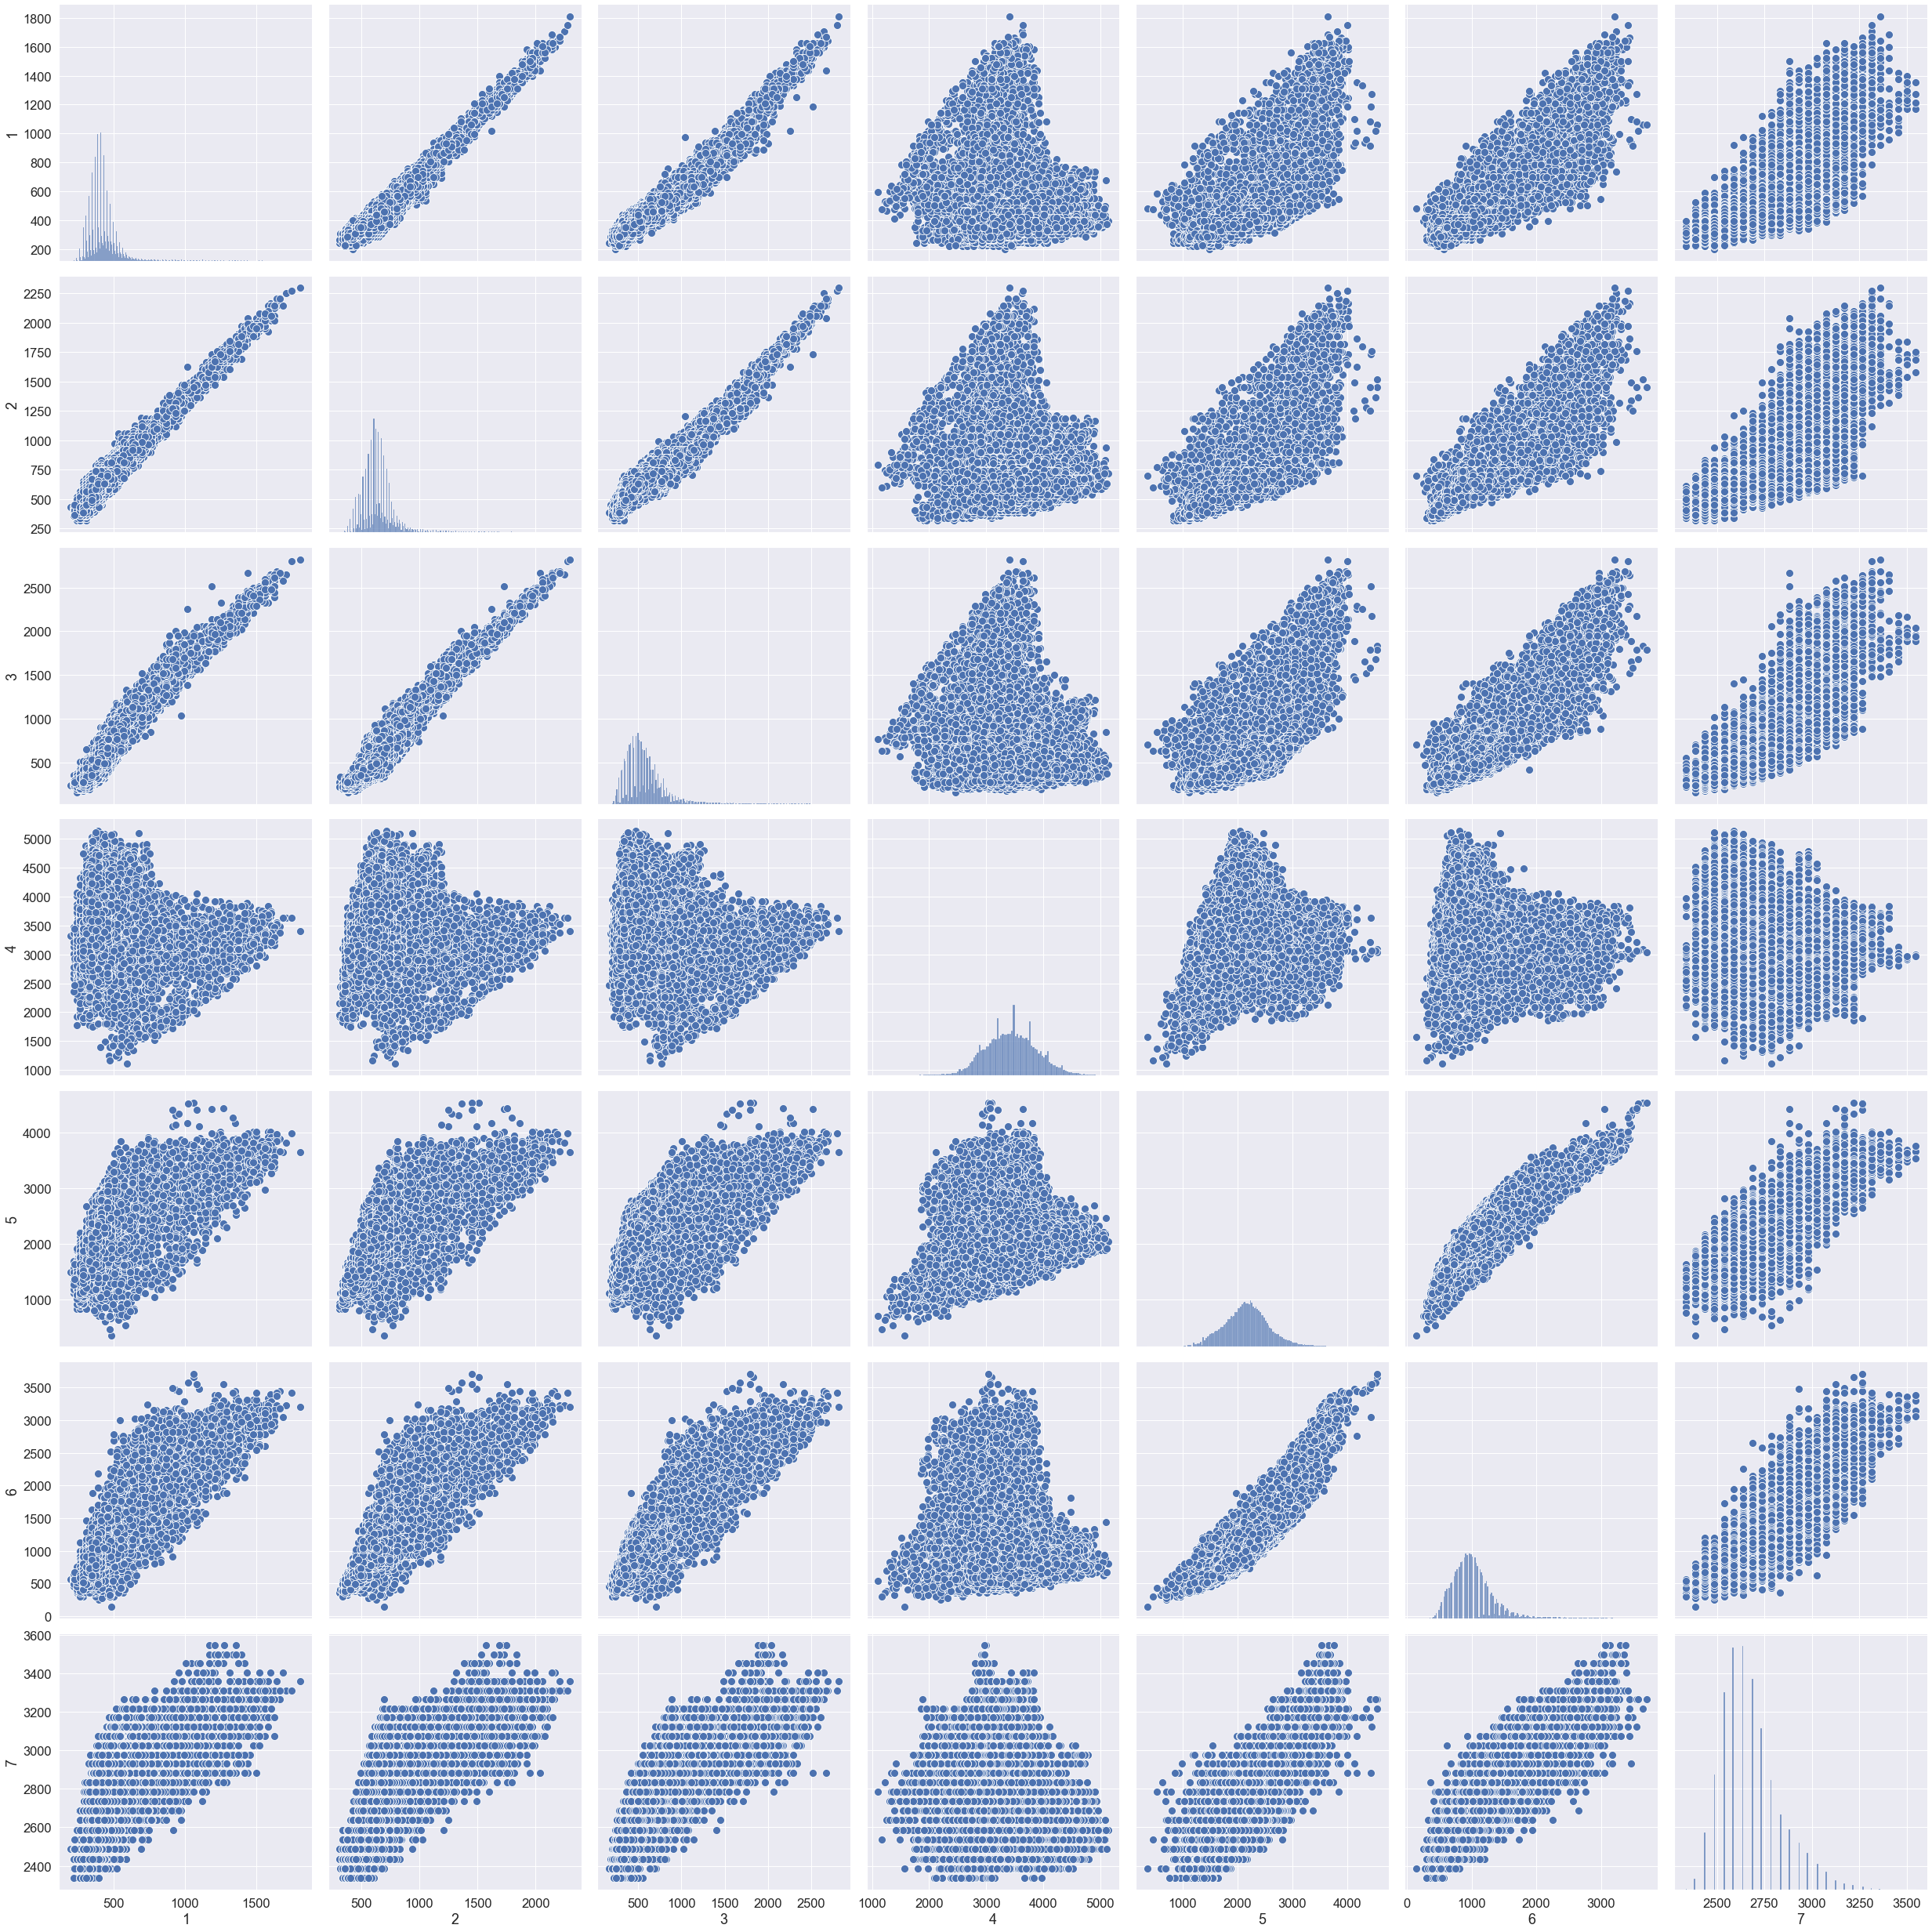

In [59]:
# As you can see, since we don't have training data, the groupings are much less 
# clear. There is a lot more noise in the data. But that's just the disadvantage
# of kmeans vs. random forests!

sns.set(font_scale=1.5)
band_list = [1, 2, 3]
sns.pairplot(landsat_df,
             height=5,
             plot_kws={"s": 100})
plt.show()

## You will get different results for different values of k
Depending on your data, some values of k will produce "better" results (we'll talk about some ways to measure this)

In [84]:
# Looping through multiple numbers of iterations
# Do we ever get a water class?
nclusters = range(3, 30)
kmeans_dict = {}
predictions = {}
for k in nclusters:
    kmeans_dict[k] = KMeans(n_clusters=k).fit(landsat_sk_xr)
    predictions[k] = (
        kmeans_dict[k]
        .predict(landsat_sk_xr)
        .reshape(landsat_xr[0, :, :].shape))

['{}, {}'.format(k, classes.max()) for k, classes in predictions.items()]

['3, 2',
 '4, 3',
 '5, 4',
 '6, 5',
 '7, 6',
 '8, 7',
 '9, 8',
 '10, 9',
 '11, 10',
 '12, 11',
 '13, 12',
 '14, 13',
 '15, 14',
 '16, 15',
 '17, 16',
 '18, 17',
 '19, 18',
 '20, 19',
 '21, 20',
 '22, 21',
 '23, 22',
 '24, 23',
 '25, 24',
 '26, 25',
 '27, 26',
 '28, 27',
 '29, 28']

### Let's take a look at some of the clusters

In [85]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i > 5:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction.transpose([1, 0]),
                   cmap="terrain",
                   interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
plt.show()

## Plotting inertia of each nclusters number to see how inertia changes with number of clusters.

This website has this explanation for inertia: https://datamahadev.com/understanding-k-means-clustering/

For a given datapoint intra-cluster distance should always be less than inter-cluster distance.

Inertia is the measure of intra-cluster distances. Data points in the same cluster should be well matched and similar to each other. Lower inertia means data points in clusters are more similar.

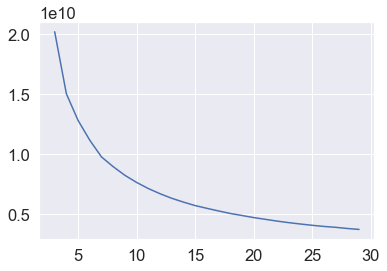

In [86]:
inertia = {k: fit.inertia_ for k, fit in kmeans_dict.items()}
plt.plot(inertia.keys(), inertia.values())